# Progress report 4 notebook

## Overview
This notebook loads and parses a sample of the XML data used in the project. A general report that includes more information about the project is available in the [project report](../docs/progress_report.md).

This notebook continues progress reports 1–3, integrating improvements, corrections, and new functionality. This is the *existing* option for report 3, renamed for easy access to and comparison of the three stages. Major changes from earlier approach (see [Progress report 3](progress_report_3.ipynb) for details) are:

1. Decomposition is into C(C)/V, rather than syllables
2. Rhymes is identified by segments, rather than distinctive features

Phonetic distinctive features will return for evaluating and analyzing rhyming lines, even if no longer for identifying them.

## Sample data

The sample dataset consists of multiple stanzas from a long poem. An artificial one-stanza extract looks like the following:

```xml
<poem opid="Eo.1">
    <stanza stanzaNo="001">
        <line lineNo="001">"Мой дядя самых честных пр<stress>а</stress>вил,</line>
        <line lineNo="002">Когда не в шутку занем<stress>о</stress>г,</line>
        <line lineNo="003">Он уважать себя заст<stress>а</stress>вил</line>
        <line lineNo="004">И лучше выдумать не м<stress>о</stress>г.</line>
        <line lineNo="005">Его пример другим на<stress>у</stress>ка;</line>
        <line lineNo="006">Но, боже мой, какая ск<stress>у</stress>ка</line>
        <line lineNo="007">С больным сидеть и день и н<stress>о</stress>чь,</line>
        <line lineNo="008">Не отходя ни шагу пр<stress>о</stress>чь!</line>
        <line lineNo="009">Какое низкое ков<stress>а</stress>рство</line>
        <line lineNo="010">Полу-живого забавл<stress>я</stress>ть,</line>
        <line lineNo="011">Ему подушки поправл<stress>я</stress>ть,</line>
        <line lineNo="012">Печально подносить лек<stress>а</stress>рство,</line>
        <line lineNo="013">Вздыхать и думать про себ<stress>я</stress>:</line>
        <line lineNo="014">Когда же чорт возьмет теб<stress>я</stress>!"</line>
    </stanza>
</poem>   
```

## Reload libraries each time, since we’re tinkering with them

In [1]:
%load_ext autoreload
%autoreload 2

## Load libraries

In [2]:
from xml.dom import pulldom  # parse input XML
from xml.dom.minidom import Document  # construct output XML
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
# see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
%matplotlib inline
import regex as re
from cyr2phon import cyr2phon  # custom package
pd.set_option('display.max_colwidth', -1) # show all text in cell, without truncation; default is 50

## Class and variables for parsing input XML

In [3]:
class Stack(list):  # keep track of open nodes while constructing XML output
    def push(self, item):
        self.append(item)

    def peek(self):  
        return self[-1]


open_elements = Stack()
WS_RE = re.compile(r'\s+')  # normalize white space in output

## Function to parse the XML

Returns a list of lists, with stanza number, line number, and `<line>` element for each line. We use the light-weight *xml.dom.pulldom* library to parse the input XML and *xml.dom.minidom* to construct the lines as simplified XML, removing elements we don’t care about, such as `<latin>` and `<italic>`, before serializing them to the output. (We actually do care about `<latin>`, but we are ignoring it temporarily, and we’ll return to it at a later stage in the project.)

In [4]:
def process(input_xml):
    poemId = ""
    stanzaNo = 0
    lineNo = 0
    inline = 0  # flag to control behavior inside and outside lines
    result = []  # array of arrays, one per line, with stanzaNo, lineNo, and serialized XML
    doc = pulldom.parse(input_xml)
    for event, node in doc:
        if event == pulldom.START_ELEMENT and node.localName == 'poem':
            poemId = node.getAttribute("opid")
        elif event == pulldom.START_ELEMENT and node.localName == 'stanza':
            stanzaNo = node.getAttribute("stanzaNo")
        elif event == pulldom.START_ELEMENT and node.localName == 'line':
            d = Document()  # each line is an output XML document
            open_elements.push(d)  # document node
            lineNo = node.getAttribute("lineNo")
            inline = 1  # we’re inside a line
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'line':
            inline = 0  # when we finish our work here, we’ll no longer be inside a line
            open_elements.pop()  # line is finished
            # serialize XML, strip declaration, rewrite &quot; entity as character
            result.append([poemId, int(stanzaNo), int(lineNo),
                WS_RE.sub(" " ,
                open_elements.pop().toxml().replace('<?xml version="1.0" ?>', '').replace('&quot;', '"'))])
        elif event == pulldom.START_ELEMENT and node.localName == 'stress':
            open_elements.peek().appendChild(node)  # add as child of current node in output tree
            open_elements.push(node)  # keep track of open elements
        elif event == pulldom.END_ELEMENT and node.localName == 'stress':
            open_elements.pop()  # stress element is finished
        elif event == pulldom.CHARACTERS and inline:  # keep text only inside lines
            t = d.createTextNode(node.data)
            open_elements.peek().appendChild(t)
    return result

## Parse the XML into an array of arrays

In [5]:
# Uncomment one of the two lines below depending on whether you have access to the full data
# data = "data_samples/eo1.xml" # public sample data
data = "../data/eo-all.xml" # private full data

with open(data) as f:
    all_lines = process(f)
all_lines[:5]  # take a look

[['Eo.1',
  1,
  1,
  '<line lineNo="001">"Мой дядя самых честных пр<stress>а</stress>вил,</line>'],
 ['Eo.1',
  1,
  2,
  '<line lineNo="002">Когда не в шутку занем<stress>о</stress>г,</line>'],
 ['Eo.1',
  1,
  3,
  '<line lineNo="003">Он уважать себя заст<stress>а</stress>вил</line>'],
 ['Eo.1',
  1,
  4,
  '<line lineNo="004">И лучше выдумать не м<stress>о</stress>г.</line>'],
 ['Eo.1',
  1,
  5,
  '<line lineNo="005">Его пример другим на<stress>у</stress>ка;</line>']]

## General descriptive information: the wrong way

Here is the wrong way to get general information; it assumes that all stanzas contain 14 lines. There are four that don’t:

1. 3.3 has 8 lines
1. 4.37 has 13 lines
1. 8.2 has 4 lines
1. 8.25 has 8 lines

In [6]:
line_count = len(all_lines)
print ('There are ' + str(line_count / 14) + ' 14-line stanzas in this sample, with a total of ' + 
       str(line_count) + ' lines.\nSince we know that the poem is fully rhymed, there are ' + 
       str(line_count / 2) + ' rhyme pairs in the sample.')

There are 364.35714285714283 14-line stanzas in this sample, with a total of 5101 lines.
Since we know that the poem is fully rhymed, there are 2550.5 rhyme pairs in the sample.


That’s all wrong. We’ll fix it after we write the data into a dataframe.

## Write the data into a dataframe

In [7]:
df = pd.DataFrame(all_lines, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
df.head(5)

,PoemId,StanzaNo,LineNo,Text
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>"
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>"
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>"
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>"
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>"


## Descriptive information about the cantos, stanzas, and lines

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5101 entries, 0 to 5100
Data columns (total 4 columns):
PoemId      5101 non-null object
StanzaNo    5101 non-null int64
LineNo      5101 non-null int64
Text        5101 non-null object
dtypes: int64(2), object(2)
memory usage: 159.5+ KB


In [9]:
cantos = df.groupby("PoemId").count()
print(cantos["StanzaNo"]) # line count by canto

PoemId
Eo.1    756
Eo.2    560
Eo.3    568
Eo.4    601
Eo.5    588
Eo.6    602
Eo.7    728
Eo.8    698
Name: StanzaNo, dtype: int64


### Stanzas with fewer than 14 lines (or, in theory, more)

In [10]:
df.groupby(["PoemId", "StanzaNo"]).filter(lambda x: x["LineNo"].count() != 14).groupby(["PoemId", "StanzaNo"]).count()["LineNo"]

PoemId  StanzaNo
Eo.3    3           8 
Eo.4    37          13
Eo.8    2           4 
        25          8 
Name: LineNo, dtype: int64

### Lines without stress

In [11]:
df[df["Text"].str.contains("stress") == False]

,PoemId,StanzaNo,LineNo,Text
2302,Eo.4,37,13,"<line lineNo=""013"">И одевался...</line>"


### Lines with non-Cyrillic stress

Rhyme reports about these lines are likely to be wrong. Do something about it eventually.

In [12]:
df[df["Text"].str.contains(r'<stress>[^а-яА-Я]</stress>')][["PoemId", "StanzaNo", "LineNo", "Text"]]

,PoemId,StanzaNo,LineNo,Text
75,Eo.1,6,6,"<line lineNo=""006"">В конце письма поставить v<stress>a</stress>le, </line>"
192,Eo.1,17,11,"<line lineNo=""011"">Готов охлопать entrech<stress>a</stress>t, </line>"
1340,Eo.3,2,11,"<line lineNo=""011"">И слез, и рифм et ceter<stress>a</stress> ?:</line>"
2187,Eo.4,28,10,"<line lineNo=""010""> Qu'écrirez-vous sur ces tabl<stress>e</stress>ttes; </line>"
2188,Eo.4,28,11,"<line lineNo=""011"">И подпись: t. à v. Ann<stress>e</stress>tte; </line>"
2368,Eo.4,43,10,"<line lineNo=""010"">Читай: вот Прадт, вот W. Sc<stress>o</stress>tt. </line>"
2856,Eo.5,27,8,"<line lineNo=""008""> Réveillez vous, belle endorm<stress>i</stress>e. </line>"
2861,Eo.5,27,13,"<line lineNo=""013"">И смело вместо belle Nin<stress>a</stress> </line>"
2862,Eo.5,27,14,"<line lineNo=""014"">Поставил belle Tatian<stress>a</stress>. </line>"
3410,Eo.6,27,2,"<line lineNo=""002"">""Вот он: мой друг, monsieur Guill<stress>o</stress>t. </line>"


## Transliterate all lines and save in new column

1. Because only the last stress in the line is marked, the phonetic representation of all words except the last is incorrect. That doesn’t matter for the analysis of end rhyme.
1. Words in foreign languages are not being treated specially, and are therefore usually phonetically incorrect. That *does* matter for the analysis of end rhyme. Deal with it later, first by excluding those lines (revise the XML parsing to record that information), and eventually by phoneticizing them correctly.
1. The `transliterate()` function is part of the [custom *cyr2phon* package](cyr2phon/cyr2phon.py).

In [13]:
trans_vec = np.vectorize(cyr2phon.transliterate)
df["Phonetic"] = trans_vec(df["Text"])
df.head()  # take a look

,PoemId,StanzaNo,LineNo,Text,Phonetic
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",maJ DiDi samix Čistnix prAVil
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",kagda Nifšutku zaNimOk
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",an uvažaT SiBi zastAVil
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",iluČši vidumaT NimOk
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",Jiva pRiMir druGim naUka


## Write the rhyme word into a new column

In [14]:
df["RhymeWord"] = df["Phonetic"].str.split().str[-1] # clitics have already been joined
df.head()  # take a look

,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",maJ DiDi samix Čistnix prAVil,prAVil
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",kagda Nifšutku zaNimOk,zaNimOk
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",an uvažaT SiBi zastAVil,zastAVil
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",iluČši vidumaT NimOk,NimOk
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",Jiva pRiMir druGim naUka,naUka


## Identify rhyme zone and write into new column

The *rhyme zone* is the portion of the line that participates in line end-rhyme. According to Russian rhyming conventions, the rhyme zone typically begins with the last stressed vowel of the line and continues until the end of the line. The one exception is that open masculine rhyme (that is, rhyme involving stress on a final syllable that ends in a vowel, e.g., **себя́** *[SiBA]*) also requires a *supporting consonant*, that is, it also requires that the consonants *before the stressed vowels* (not otherwise considered part of the rhyme zone* also agree. For example:

* _see_ and _tree_ do not rhyme in Russian because this open (ends in a vowel sound) masculine (stress on the final syllable) rhyme does not have a supporting consonant (consonants before the stressed vowels do not agree).
* *seat* and *treat* do rhyme in Russian because closed (ends in a consonant sound) masculine (stress on the final syllable) rhyme does not require a supporting consonant, so the lack of phonetic correspondence between the consonants before the stressed vowels does not matter.

Russian rhyme may also be *enriched* by phonetic agreement or similarity outside the rhyme zone. For example, *stop* and *strop* constitute a perfect rhyme because the *op* sounds match. Nonetheless, the match of *st* before the rhyme zone enhances, or enriches, the rhyme. The present study ignores enrichment and concentrates only on the core rhyme components, but enrichment will be incorporated into the analysis at a later stage.

With that said, this first pass at identifying the rhyme zone removes the pretonic segments, but not the final consonant of a pretonic onset where a supporting consonant is not needed. More cleaning to follow!

In [15]:
rhymezonepat = re.compile(r'(.?[AEIOU]$)|([AEIOU].*$)')
def remove_pretonic_segments(s: str) -> str: # removes segments in place
    try:
        return rhymezonepat.search(s).group(0)
    except: # modify this to raise a real error, instead of just reporting
        print(s)
df["RhymeZone"] = df["RhymeWord"].apply(remove_pretonic_segments)
df.head(14)

iaDivalSi
têti-à-tÊti


,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord,RhymeZone
0,Eo.1,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",maJ DiDi samix Čistnix prAVil,prAVil,AVil
1,Eo.1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",kagda Nifšutku zaNimOk,zaNimOk,Ok
2,Eo.1,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",an uvažaT SiBi zastAVil,zastAVil,AVil
3,Eo.1,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",iluČši vidumaT NimOk,NimOk,Ok
4,Eo.1,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",Jiva pRiMir druGim naUka,naUka,Uka
5,Eo.1,1,6,"<line lineNo=""006"">Но, боже мой, какая ск<stress>у</stress>ка</line>",nabaži maJ kakaJi skUka,skUka,Uka
6,Eo.1,1,7,"<line lineNo=""007"">С больным сидеть и день и н<stress>о</stress>чь,</line>",zbaLnim SiDiT iDiN inOČ,inOČ,OČ
7,Eo.1,1,8,"<line lineNo=""008"">Не отходя ни шагу пр<stress>о</stress>чь!</line>",NiatxaDi Nišagu prOČ,prOČ,OČ
8,Eo.1,1,9,"<line lineNo=""009"">Какое низкое ков<stress>а</stress>рство</line>",kakaJi NiskaJi kavArstva,kavArstva,Arstva
9,Eo.1,1,10,"<line lineNo=""010"">Полу-живого забавл<stress>я</stress>ть,</line>",palu-živava zabavLAT,zabavLAT,AT


## Tokenize rhyme zone into C(C) and V

We may have some null values in the rhyme zone for incomplete lines that have no final stressed syllable (*EO* 37: 13) and foreign words that we may not be handling properly (*EO* 23:2). Check for those:

In [16]:
df[df["RhymeZone"].isnull()]

,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord,RhymeZone
2302,Eo.4,37,13,"<line lineNo=""013"">И одевался...</line>",iaDivalSi,iaDivalSi,None
4702,Eo.8,23,2,"<line lineNo=""002"">Сей неприятный tête-à-t<stress>ê</stress>te; </line>",SiJ NipRiJitniJ têti-à-tÊti,têti-à-tÊti,None


Filter them out provisionally by writing in a placeholder value:

In [17]:
df.loc[df["RhymeZone"].isnull(), "RhymeZone"] = "Abcde"
df[df["RhymeZone"] == "Abcde"]

,PoemId,StanzaNo,LineNo,Text,Phonetic,RhymeWord,RhymeZone
2302,Eo.4,37,13,"<line lineNo=""013"">И одевался...</line>",iaDivalSi,iaDivalSi,Abcde
4702,Eo.8,23,2,"<line lineNo=""002"">Сей неприятный tête-à-t<stress>ê</stress>te; </line>",SiJ NipRiJitniJ têti-à-tÊti,têti-à-tÊti,Abcde


In [18]:
df["tokenized"] = [x[0] for x in df["RhymeZone"].str.
                   findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]
i = 0
while pd.np.count_nonzero([item[i] for item in df["tokenized"]]) > 0:
    # print([item[i] for item in df["tokenized"]]) # diagnostic
    df["token" + str(i)] = [item[i] for item in df["tokenized"]]
    i += 1
tokenheaders = df.filter(regex="^token\d").columns
# tokenheaders = list([item for item in df.columns if re.match(r'token\d', item)])
df[tokenheaders] = df[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
df.filter(regex=r"StanzaNo|LineNo|RhymeWord|Text|^token\d").head() # columns we care about

,StanzaNo,LineNo,Text,RhymeWord,token0,token1,token2,token3,token4,token5
0,1,1,"<line lineNo=""001"">""Мой дядя самых честных пр<stress>а</stress>вил,</line>",prAVil,missing,A,V,i,l,missing
1,1,2,"<line lineNo=""002"">Когда не в шутку занем<stress>о</stress>г,</line>",zaNimOk,missing,O,k,missing,missing,missing
2,1,3,"<line lineNo=""003"">Он уважать себя заст<stress>а</stress>вил</line>",zastAVil,missing,A,V,i,l,missing
3,1,4,"<line lineNo=""004"">И лучше выдумать не м<stress>о</stress>г.</line>",NimOk,missing,O,k,missing,missing,missing
4,1,5,"<line lineNo=""005"">Его пример другим на<stress>у</stress>ка;</line>",naUka,missing,U,k,a,missing,missing


## One-hot encode token columns

`df = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)` will replace the original categorical values with binary ones. The approach below keeps both and avoids duplication.

In [19]:
# Danger: don’t rerun this; it will one-hot encode the output of the previous one-hot encoding!
dummy = pd.get_dummies(df, columns=df.filter(regex="^token\d").columns, drop_first=True)

In [20]:
df = df.merge(dummy, on=["PoemId", "StanzaNo", "LineNo", "Text", "Phonetic", "RhymeWord", "RhymeZone", "tokenized"])

In [21]:
# Multindex on PoemId (canto), StanzaNo, and LineNo; stanza will be rhyme domain
df.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
df

Text  \
PoemId StanzaNo LineNo                                                                                    
Eo.1   1        1       <line lineNo="001">"Мой дядя самых честных пр<stress>а</stress>вил,</line>        
                2       <line lineNo="002">Когда не в шутку занем<stress>о</stress>г,</line>              
                3       <line lineNo="003">Он уважать себя заст<stress>а</stress>вил</line>               
                4       <line lineNo="004">И лучше выдумать не м<stress>о</stress>г.</line>               
                5       <line lineNo="005">Его пример другим на<stress>у</stress>ка;</line>               
                6       <line lineNo="006">Но, боже мой, какая ск<stress>у</stress>ка</line>              
                7       <line lineNo="007">С больным сидеть и день и н<stress>о</stress>чь,</line>        
                8       <line lineNo="008">Не отходя ни шагу пр<stress>о</stress>чь!</line>               
                9       <line lineNo="009">Какое низкое ков<stress>а</stress>рство</line>                 
                10      <line lineNo="010">Полу-живого забавл<stress>я</stress>ть,</line>                 
                11      <line lineNo="011">Ему подушки поправл<stress>я</stress>ть,</line>                
                12      <line lineNo="012">Печально подносить лек<stress>а</stress>рство,</line>          
                13      <line lineNo="013">Вздыхать и думать про себ<stress>я</stress>:</line>            
                14      <line lineNo="014">Когда же чорт возьмет теб<stress>я</stress>!"</line>           
       2        1       <line lineNo="001">Так думал молодой пов<stress>е</stress>са,</line>              
                2       <line lineNo="002">Летя в пыли на почтов<stress>ы</stress>х,</line>               
                3       <line lineNo="003">Всевышней волею Зев<stress>е</stress>са</line>                 
                4       <line lineNo="004">Наследник всех своих родн<stress>ы</stress>х.—</line>          
                5       <line lineNo="005">Друзья Людмилы и Русл<stress>а</stress>на!</line>              
                6       <line lineNo="006">С героем моего ром<stress>а</stress>на</line>                  
                7       <line lineNo="007">Без предисловий, сей же ч<stress>а</stress>с</line>            
                8       <line lineNo="008">Позвольте познакомить в<stress>а</stress>с:</line>             
                9       <line lineNo="009">Онегин, добрый мой при<stress>я</stress>тель,</line>           
                10      <line lineNo="010">Родился на брегах Нев<stress>ы</stress>,</line>                
                11      <line lineNo="011">Где может быть родились в<stress>ы</stress>,</line>            
                12      <line lineNo="012">Или блистали, мой чит<stress>а</stress>тель;</line>            
                13      <line lineNo="013">Там некогда гулял и <stress>я</stress>:</line>                 
                14      <line lineNo="014">Но вреден север для мен<stress>я</stress>.</line>              
       3        1       <line lineNo="001">Служив отлично-благор<stress>о</stress>дно,</line>             
                2       <line lineNo="002">Долгами жил его от<stress>е</stress>ц,</line>                  
...                                                                                       ...             
Eo.8   49       13      <line lineNo="013">Хотя крупицу мог найт<stress>и</stress>.</line>                
                14      <line lineNo="014">За сим расстанемся, прост<stress>и</stress>!</line>            
       50       1       <line lineNo="001">Прости ж и ты, мой спутник стр<stress>а</stress>нный,</line>   
                2       <line lineNo="002">И ты, мой верный Иде<stress>а</stress>л,</line>                
                3       <line lineNo="003">И ты, живой и посто<stress>я</stress>нный,</line>              
                4       <line lin

## Is rhyme identification a supervised or unsupervised question?

### Unsupervised

#### Overview

An *unsupervised* approach to rhyme identification regards it as a *clustering* problem. Within the domain to be searched (e.g., stanza, sliding window of four lines):

1. Form clusters hierarchically according to shortest distance. 
1. Determine where the clustering makes a transition from informational to artifactual.

#### Observations

* There is no separation of training and testing sets and no predefined rhymed or non-rhymed assessments for line pairs. 
* The method does not require pairwise line comparison—except insofar as that is implicit in the black box that performs the clustering.
* The method naturally recognizes degree or confidence of rhyme identification: except as mediated by interlinear distamce, it should cluster perfect rhyme first, and then increasingly approximate rhyme, a hierarchy that is consistent with human intuition.

#### Issues

* **Parameters.** The *linkage* (clustering method: simple, complete, Ward’s, centroid) and *affinity* (distance measure: Euclidean, Manhattan) are to be determined (perhaps with GridSearch?). 
* **Scaling.** One-hot encoded segment information is binary and proximity (represented by line number) is ordinal. Should they be normalized? On the one hand, if they aren’t, distance might dwarf the binary features. On the other hand, does distance have an absolute quality? For example, being within 10% of the line count in a ten-line stanza is adjacent, and therefore meaningful. In a hundred-line non-stanzaic poem, though, it is distant and of dubious significance.
* **Weighting.** At least once scaling has been applied, all features are weighted similarly. Should they be? Can the system advise us about preferential weighting?
* **Feedback.** It is unclear how the results of a clustering analysis can be translated into eventual weighting information. Since we know the correct outcome, we can identify correct and incorrect results. Can we feed that back into weighting adjustments?
* **Phonetic distinctive features.** We don’t yet see a way to perform comparison at the level of phonetic distinctive features as long as consonant clusters of different lengths may be aligned. But we could decompose vowels, since those are always singletons. Is it useful (or even practical) to decompose some segments and not others? We could test whether features matter by looking for statistically significant differences among the three unstressed vowels, *[i, u, a]*.
* **Enrichment.** At the moment we ignore pretonic information, but it should be incorporated,  even if only at a lower weight. For the moment the pretonic consonant is relevant only for open masculine rhyme, and in that case it is always a singleton, and therefore amenable to feature decomposition (see immediately above). Once we incorporate enrichment, though, does the pretonic cluster become more important than the pretonic consonant?

## Exploratory dendrograms

Generate dendrograms for first 10 stanzas (1–11, since 9 is missing).

In addition to the one-hot-encoded C(C) ~ V information, line number is treated as a feature, under the assumption that rhyme involves not only phonetic similarity, but also proximity. Earlier trials with raw line numbers (which range from 1–14 with this data set) distorted the output, so the values are normalized (scaled), by trial and error, to range from 0–2. Initial linkage method are complete Ward; for discussion of options see:

* <https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/> (Start here)
* <https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering>
* <https://stats.stackexchange.com/questions/63546/comparing-hierarchical-clustering-dendrograms-obtained-by-different-distances/63549#63549>
* <https://stats.stackexchange.com/questions/3713/choosing-a-clustering-method>
* <https://stats.stackexchange.com/questions/195456/how-to-select-a-clustering-method-how-to-validate-a-cluster-solution-to-warran>

Output includes complete and Ward dendrograms with cophenetic correlation coefficient (see <https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/>); a value closer to 1 means that the clustering does a better job of preserving the actual distances. 

                                                   Text  RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                      
Eo.1   1        1       "Мой дядя самых честных правил,  prAVil     AVil    
                2       Когда не в шутку занемог,        zaNimOk    Ok      
                3       Он уважать себя заставил         zastAVil   AVil    
                4       И лучше выдумать не мог.         NimOk      Ok      
                5       Его пример другим наука;         naUka      Uka     
                6       Но, боже мой, какая скука        skUka      Uka     
                7       С больным сидеть и день и ночь,  inOČ       OČ      
                8       Не отходя ни шагу прочь!         prOČ       OČ      
                9       Какое низкое коварство           kavArstva  Arstva  
                10      Полу-живого забавлять,           zabavLAT   AT      
                11      Ему подушки поправлять,          papravLAT  AT      

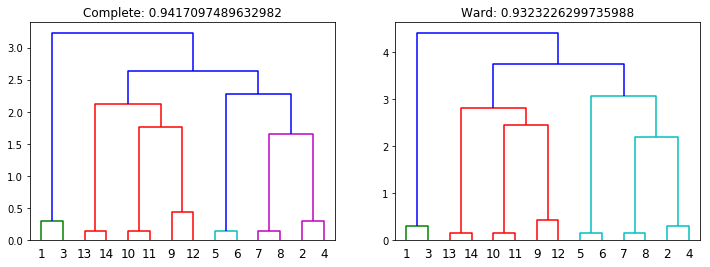

                                                 Text   RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                     
Eo.1   2        1       Так думал молодой повеса,      paVEsa      Esa     
                2       Летя в пыли на почтовых,       napaČtavIx  Ix      
                3       Всевышней волею Зевеса         ZiVEsa      Esa     
                4       Наследник всех своих родных.—  radnIx      Ix      
                5       Друзья Людмилы и Руслана!      iruslAna    Ana     
                6       С героем моего романа          ramAna      Ana     
                7       Без предисловий, сей же час    ČAs         As      
                8       Позвольте познакомить вас:     vAs         As      
                9       Онегин, добрый мой приятель,   pRiJATiL    ATiL    
                10      Родился на брегах Невы,        NivI        vI      
                11      Где может быть родились вы,    vI          vI      
            

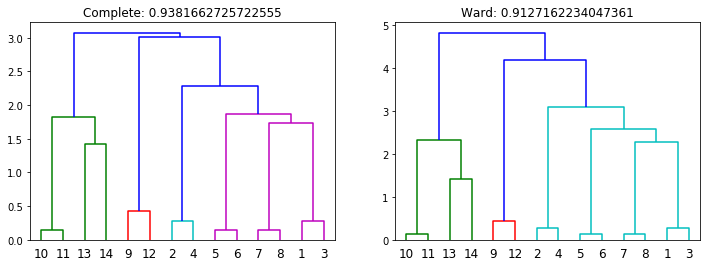

                                                     Text           RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                                 
Eo.1   3        1       Служив отлично-благородно,         aTLiČna-blagarOdna  Odna    
                2       Долгами жил его отец,              aTEts               Ets     
                3       Давал три бала ежегодно            JižigOdna           Odna    
                4       И промотался наконец.              nakaNEts            Ets     
                5       Судьба Евгения хранила:            xraNIla             Ila     
                6       Сперва Madame за ним ходила,       xaDIla              Ila     
                7       Потом Monsieur ее сменил;          sMiNIl              Il      
                8       Ребенок был резов, но мил.         naMIl               Il      
                9        Monsieur l'Abbé, француз убогой,  ubOgaJ              OgaJ    
                10      Чтоб не 

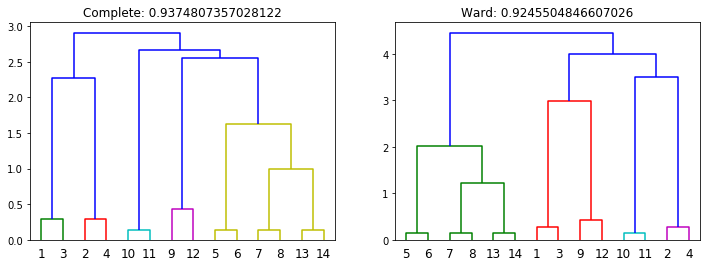

                                                  Text     RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                        
Eo.1   4        1       Когда же юности мятежной        MiTEžnaJ      EžnaJ   
                2       Пришла Евгению пора,            parA          rA      
                3       Пора надежд и грусти нежной,    NEžnaJ        EžnaJ   
                4        Monsieur прогнали со двора.    sadvarA       rA      
                5       Вот мой Онегин на свободе;      nasvabODi     ODi     
                6       Острижен по последней моде;     mODi          ODi     
                7       Как dandy лондонской одет—      aDEt          Et      
                8       И наконец увидел свет.          sVEt          Et      
                9       Он по-французски совершенно     saViršEna     Ena     
                10      Мог изьясняться и писал;        iPisAl        Al      
                11      Легко мазурку танцовал,     

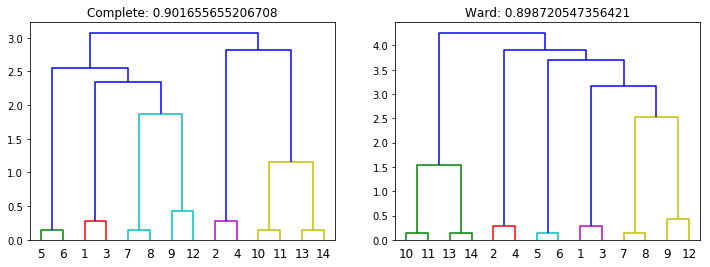

                                                    Text   RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                        
Eo.1   5        1       Мы все учились понемногу          paNimnOgu   Ogu     
                2       Чему-нибудь и как-нибудь,         ikak-NibUT  UT      
                3       Так воспитаньем, слава богу,      bOgu        Ogu     
                4       У нас немудрено блеснуть.         bLisnUT     UT      
                5       Онегин был по мненью многих       mnOGix      OGix    
                6       (Судей решительных и строгих)     istrOGix    OGix    
                7       Ученый малый, но педант:          naPidAnt    Ant     
                8       Имел он счастливый талант         talAnt      Ant     
                9       Без принужденья в разговоре       vrazgavORi  ORi     
                10      Коснуться до всего слегка,        SLikA       kA      
                11      С ученым видом знатока      

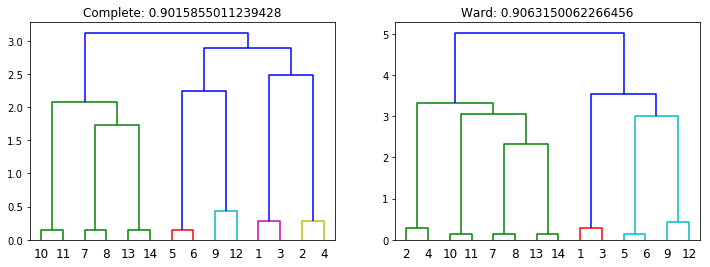

                                                   Text   RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                       
Eo.1   6        1       Латынь из моды вышла ныне:       nINi        INi     
                2       Так, если правду вам сказать,    skazAT      AT      
                3       Он знал довольно по-латыне,      pa-latINi   INi     
                4       Чтоб эпиграфы разбирать,         razBirAT    AT      
                5       Потолковать об Ювенале,          aBuVinALi   ALi     
                6       В конце письма поставить vale,   vAli        Ali     
                7       Да помнил, хоть не без греха,    NiBizgRixA  xA      
                8       Из Энеиды два стиха.             STixA       xA      
                9       Он рыться не имел охоты          axOti       Oti     
                10      В хронологической пыли           piLI        LI      
                11      Бытописания земли:               ZimLI  

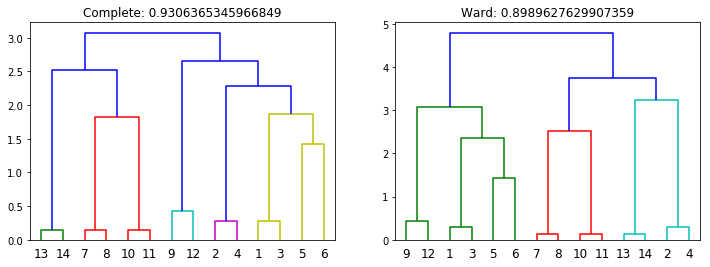

                                                Text  RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                   
Eo.1   7        1       Высокой страсти не имея       NiJiMEJi   EJi     
                2       Для звуков жизни не щадить,   NiQaDIT    IT      
                3       Не мог он ямба от хорея,      atxaREJi   EJi     
                4       Как мы ни бились, отличить.   aTLiČIT    IT      
                5       Бранил Гомера, Феокрита;      FiakRIta   Ita     
                6       За то читал Адама Смита,      sMIta      Ita     
                7       И был глубокой эконом,        ikanOm     Om      
                8       То есть, умел судить о том,   atOm       Om      
                9       Как государство богатеет,     bagaTEJit  EJit    
                10      И чем живет, и почему         ipaČimU    mU      
                11      Не нужно золота ему,          JimU       mU      
                12      Когда простой 

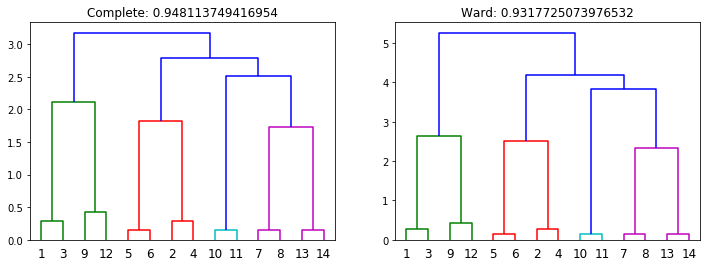

                                                   Text  RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                      
Eo.1   8        1       Всего, что знал еще Евгений,     JivGENiJ   ENiJ    
                2       Пересказать мне недосуг;         NidasUk    Uk      
                3       Но в чем он истинный был гений,  GENiJ      ENiJ    
                4       Что знал он тверже всех наук,    naUk       Uk      
                5       Что было для него измлада        izmlAda    Ada     
                6       И труд и мука и отрада,          iatrAda    Ada     
                7       Что занимало целый день          DEN        EN      
                8       Его тоскующую лень,—             LEN        EN      
                9       Была наука страсти нежной,       NEžnaJ     EžnaJ   
                10      Которую воспел Назон,            nazOn      On      
                11      За что страдальцем кончил он     On         On      

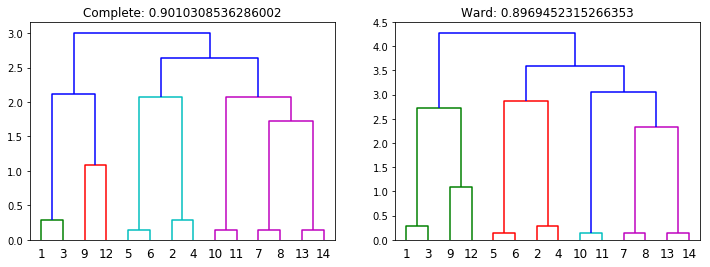

                                                     Text      RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                            
Eo.1   10       1       Как рано мог он лицемерить,        LitsiMERiT     ERiT    
                2       Таить надежду, ревновать,          RivnavAT       AT      
                3       Разуверять, заставить верить,      VERiT          ERiT    
                4       Казаться мрачным, изнывать,        iznivAT        AT      
                5       Являться гордым и послушным,       ipaslUšnim     Ušnim   
                6       Внимательным, иль равнодушным!     iLravnadUšnim  Ušnim   
                7       Как томно был он молчалив,         malČiLIf       If      
                8       Как пламенно красноречив,          krasnaRiČIf    If      
                9       В сердечных письмах как небрежен!  NibREžin       Ežin    
                10      Одним дыша, одно любя,             LuBA           BA      
    

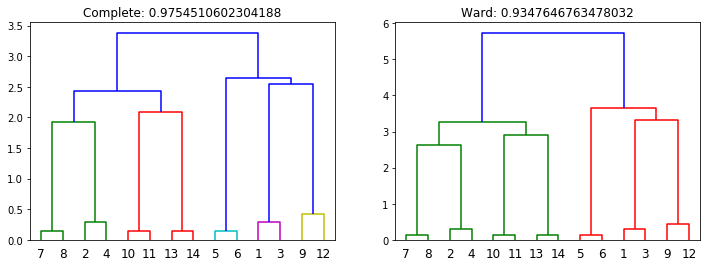

                                                  Text      RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                         
Eo.1   11       1       Как он умел казаться новым,     nOvim          Ovim    
                2       Шутя невинность изумлять,       izumLAT        AT      
                3       Пугать отчаяньем готовым,       gatOvim        Ovim    
                4       Приятной лестью забавлять,      zabavLAT       AT      
                5       Ловить минуту умиленья,         uMiLENJi       ENJi    
                6       Невинных лет предубежденья      pRiduBižDENJi  ENJi    
                7       Умом и страстью побеждать,      paBiždAT       AT      
                8       Невольной ласки ожидать,        ažidAT         AT      
                9       Молить и требовать признанья,   pRiznANJi      ANJi    
                10      Подслушать сердца первый звук,  zvUk           Uk      
                11      Преследовать люб

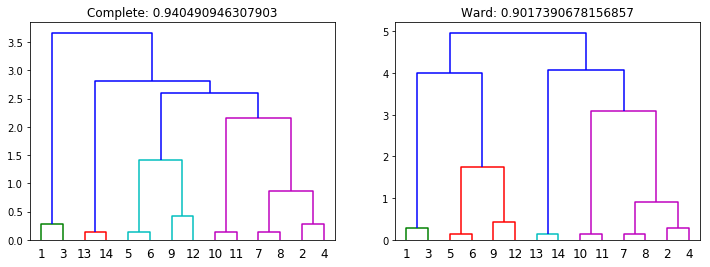

                                                Text  RhymeWord RhymeZone
PoemId StanzaNo LineNo                                                   
Eo.1   12       1       Как рано мог уж он тревожить  tRivOžiT   OžiT    
                2       Сердца кокеток записных!      zaPisnIx   Ix      
                3       Когда ж хотелось уничтожить   uNiČtOžiT  OžiT    
                4       Ему соперников своих,         svaJIx     Ix      
                5       Как он язвительно злословил!  zlaslOVil  OVil    
                6       Какие сети им готовил!        gatOVil    OVil    
                7       Но вы, блаженные мужья,       mužJA      JA      
                8       С ним оставались вы друзья:   druZJA     JA      
                9       Его ласкал супруг лукавый,    lukAviJ    AviJ    
                10      Фобласа давний ученик,        uČiNIk     Ik      
                11      И недоверчивый старик,        staRIk     Ik      
                12      И рогоносец ве

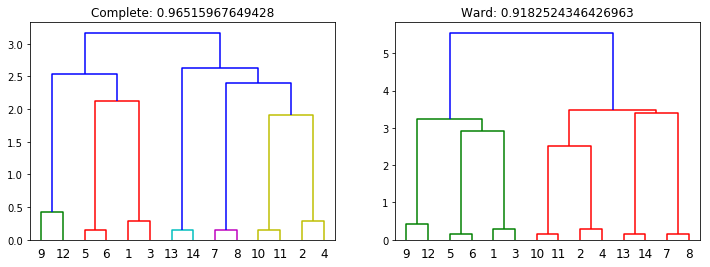

In [22]:
stanzas = df.groupby(level=[0,1])
pd.set_option('display.width', 1000) # don't wrap long rows
i = 0
for id, lines in stanzas:
    if i < 11:
        print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), lines[["RhymeWord", "RhymeZone"]]], axis=1)) # diagnostic
        data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
        labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
        data.loc[:,"LineNo"] = [2 * n / len(labelList) for n in labelList] # scale to avoid tyranny of proximity
        complete = linkage(data,method="complete")
        complete_c, complete_coph_dist = cophenet(complete, pdist(data))
        ward = linkage(data, method="ward")
        ward_c, ward_coph_dists = cophenet(ward, pdist(data))
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.title("Complete: " + str(complete_c))
        dendrogram(complete, labels=labelList)
        plt.subplot(1, 2, 2)
        plt.title("Ward: " + str(ward_c))
        dendrogram(ward, labels=labelList)
        plt.show()
    i += 1
pd.set_option('display.width', 80) # restore default

## Let’s try with Gippius, “Neljubov′” (1907)

```xml
<poem opid="gippius_neljubov">
    <stanza stanzaNo="001">
       <line lineNo="001">Как ветер мокрый, ты бьешься в ст<stress>а</stress>вни,</line>
       <line lineNo="002">Как ветер черный, поешь: ты м<stress>о</stress>й!</line>
       <line lineNo="002">Я древний хаос, я друг твой д<stress>а</stress>вний,</line>
       <line lineNo="004">Твой друг единый,— открой, откр<stress>о</stress>й!</line>
    </stanza>
    <stanza stanzaNo="002">
       <line lineNo="001">Держу я ставни, открыть не см<stress>е</stress>ю,</line>
       <line lineNo="002">Держусь за ставни и страх та<stress>ю</stress>.</line>
       <line lineNo="003">Храню, лелею, храню, жал<stress>е</stress>ю</line>
       <line lineNo="004">Мой луч последний — любовь мо<stress>ю</stress>.</line>
    </stanza>
    <stanza stanzaNo="003">
       <line lineNo="001">Смеется хаос, зовет без<stress>о</stress>кий:</line>
       <line lineNo="002">Умрешь в оковах,— порви, порв<stress>и</stress>!</line>
       <line lineNo="003">Ты знаешь счастье, ты один<stress>о</stress>кий,</line>
       <line lineNo="004">В свободе счастье — и в Нелюбв<stress>и</stress>.</line>
    </stanza>
    <stanza stanzaNo="004">
       <line lineNo="001">Охладевая, творю мол<stress>и</stress>тву,</line>
       <line lineNo="002">Любви молитву едва твор<stress>ю</stress>…</line>
       <line lineNo="003">Слабеют руки, кончаю б<stress>и</stress>тву,</line>
       <line lineNo="004">Слабеют руки… Я отвор<stress>ю</stress>!</line>
    </stanza>
</poem>
```

### Prepare the dataframe

In [23]:
data = "data_samples/gippius_neljubov.xml" # private full data
with open(data) as f:
    all_lines = process(f)
all_lines[:5]  # take a look

[['gippius_neljubov',
  1,
  1,
  '<line lineNo="001">Как ветер мокрый, ты бьешься в ст<stress>а</stress>вни,</line>'],
 ['gippius_neljubov',
  1,
  2,
  '<line lineNo="002">Как ветер черный, поешь: ты м<stress>о</stress>й!</line>'],
 ['gippius_neljubov',
  1,
  2,
  '<line lineNo="002">Я древний хаос, я друг твой д<stress>а</stress>вний,</line>'],
 ['gippius_neljubov',
  1,
  4,
  '<line lineNo="004">Твой друг единый,— открой, откр<stress>о</stress>й!</line>'],
 ['gippius_neljubov',
  2,
  1,
  '<line lineNo="001">Держу я ставни, открыть не см<stress>е</stress>ю,</line>']]

### Prepare the data for clustering

In [24]:
df_gippius_neljubov = pd.DataFrame(all_lines, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
df_gippius_neljubov["Phonetic"] = trans_vec(df_gippius_neljubov["Text"])
df_gippius_neljubov["RhymeWord"] = df_gippius_neljubov["Phonetic"].str.split().str[-1]
df_gippius_neljubov["RhymeZone"] = df_gippius_neljubov["RhymeWord"].apply(remove_pretonic_segments)
df_gippius_neljubov["tokenized"] = [x[0] for x in df_gippius_neljubov["RhymeZone"].str.
                   findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]
i = 0
while pd.np.count_nonzero([item[i] for item in df_gippius_neljubov["tokenized"]]) > 0:
    df_gippius_neljubov["token" + str(i)] = [item[i] for item in df_gippius_neljubov["tokenized"]]
    i += 1
tokenheaders = df_gippius_neljubov.filter(regex="^token\d").columns
df_gippius_neljubov[tokenheaders] = df_gippius_neljubov[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
dummy = pd.get_dummies(df_gippius_neljubov, columns=df_gippius_neljubov.filter(regex="^token\d").columns, drop_first=True)
df_gippius_neljubov = df_gippius_neljubov.merge(dummy, on=["PoemId", "StanzaNo", "LineNo", "Text", "Phonetic", "RhymeWord", "RhymeZone", "tokenized"])
df_gippius_neljubov.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
df_gippius_neljubov.head()

Text  \
PoemId           StanzaNo LineNo                                                                                      
gippius_neljubov 1        1       <line lineNo="001">Как ветер мокрый, ты бьешься в ст<stress>а</stress>вни,</line>   
                          2       <line lineNo="002">Как ветер черный, поешь: ты м<stress>о</stress>й!</line>         
                          2       <line lineNo="002">Я древний хаос, я друг твой д<stress>а</stress>вний,</line>      
                          4       <line lineNo="004">Твой друг единый,— открой, откр<stress>о</stress>й!</line>       
                 2        1       <line lineNo="001">Держу я ставни, открыть не см<stress>е</stress>ю,</line>         

                                                           Phonetic RhymeWord  \
PoemId           StanzaNo LineNo                                                
gippius_neljubov 1        1       kak ViTir makriJti BJišSi fstAvNi  fstAvNi    
                          2       kak ViTir ČirniJ paJišti mOJ       mOJ        
                          2       Ji dRivNiJ xaaSi druk tvaJ dAvNiJ  dAvNiJ     
                          4       tvaJ druk JiDiniJ atkraJ atkrOJ    atkrOJ     
                 2        1       DiržuJi stavNi atkriT NisMEJu      NisMEJu    

                                 RhymeZone  \
PoemId           StanzaNo LineNo             
gippius_neljubov 1        1       AvNi       
                          2       OJ         
                          2       AvNiJ      
                          4       OJ         
                 2        1       EJu        

                                                                  tokenized  \
PoemId           StanzaNo LineNo                                              
gippius_neljubov 1        1       (, A, vN, i, , , , , , , , , , , , , , )    
                          2       (, O, J, , , , , , , , , , , , , , , )      
                          2       (, A, vN, i, J, , , , , , , , , , , , , )   
                          4       (, O, J, , , , , , , , , , , , , , , )      
                 2        1       (, E, J, u, , , , , , , , , , , , , , )     

                                   token0 token1 token2   token3   token4  \
PoemId           StanzaNo LineNo                                            
gippius_neljubov 1        1       missing  A      vN     i        missing   
                          2       missing  O      J      missing  missing   
                          2       missing  A      vN     i        J         
                          4       missing  O      J      missing  missing   
                 2        1       missing  E      J      u        missing   

                                  ...  token1_I  token1_O  token1_U  token2_K  \
PoemId           StanzaNo LineNo  ...                                           
gippius_neljubov 1        1       ...  0         0         0         0          
                          2       ...  0         1         0         0          
                          2       ...  0         0         0         0          
                          4       ...  0         1         0         0          
                 2        1       ...  0         0         0         0          

                                  token2_missing  token2_tv  token2_vN  \
PoemId           StanzaNo LineNo                                         
gippius_neljubov 1        1       0               0          1           
                          2       0               0          0           
                          2       0               0          1           
                          4       0               0          0           
                 2        1       0               0          0           

                                  token3_missing  token3_u  token4_missing  
PoemId           StanzaNo LineNo                                            
gippius_neljubov 1        1       0               0

### Visualize

                                                                    Text RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                            
gippius_neljubov 1        1       Как ветер мокрый, ты бьешься в ставни,  fstAvNi   AvNi    
                          2       Как ветер черный, поешь: ты мой!        mOJ       OJ      
                          2       Я древний хаос, я друг твой давний,     dAvNiJ    AvNiJ   
                          4       Твой друг единый,— открой, открой!      atkrOJ    OJ      


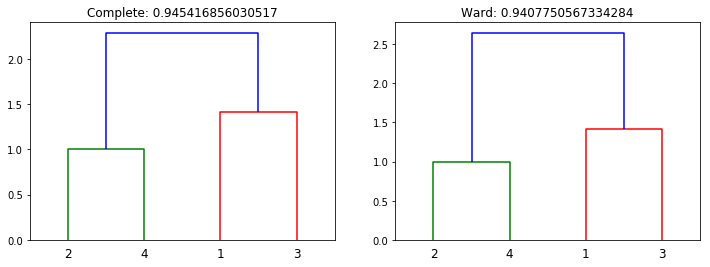

                                                              Text RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                      
gippius_neljubov 2        1       Держу я ставни, открыть не смею,  NisMEJu   EJu     
                          2       Держусь за ставни и страх таю.    taJU      JU      
                          3       Храню, лелею, храню, жалею        žaLEJu    EJu     
                          4       Мой луч последний — любовь мою.   maJU      JU      


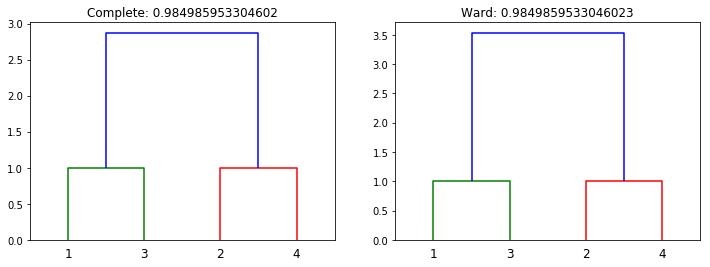

                                                              Text  RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                       
gippius_neljubov 3        1       Смеется хаос, зовет безокий:      BizOKiJ    OKiJ    
                          2       Умрешь в оковах,— порви, порви!   parVI      VI      
                          3       Ты знаешь счастье, ты одинокий,   aDinOKiJ   OKiJ    
                          4       В свободе счастье — и в Нелюбви.  ivNiLubVI  VI      


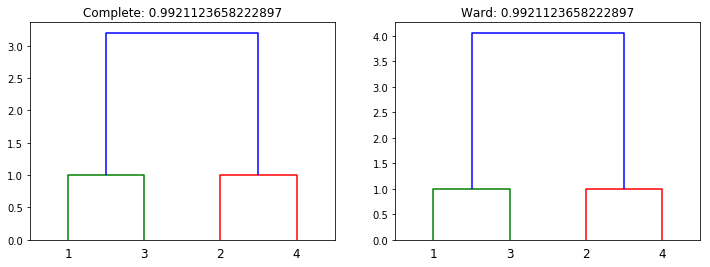

                                                         Text RhymeWord RhymeZone
PoemId           StanzaNo LineNo                                                 
gippius_neljubov 4        1       Охладевая, творю молитву,    maLItvu   Itvu    
                          2       Любви молитву едва творю…    tvaRU     RU      
                          3       Слабеют руки, кончаю битву,  BItvu     Itvu    
                          4       Слабеют руки… Я отворю!      atvaRU    RU      


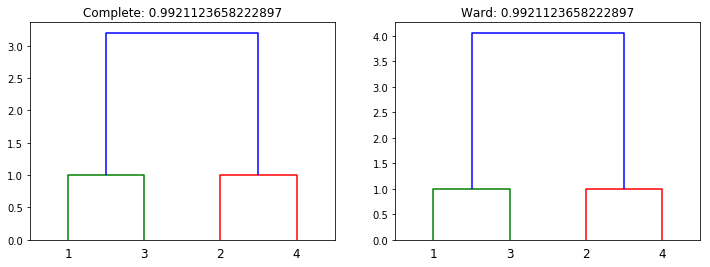

In [25]:
stanzas = df_gippius_neljubov.groupby(level=[0,1])
pd.set_option('display.width', 1000) # don't wrap long rows
for id, lines in stanzas:
    print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), lines[["RhymeWord", "RhymeZone"]]], axis=1)) # diagnostic
    data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
    labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
    data.loc[:,"LineNo"] = [2 * n / len(labelList) for n in labelList] # scale to avoid tyranny of proximity
    complete = linkage(data,method="complete")
    complete_c, complete_coph_dist = cophenet(complete, pdist(data))
    ward = linkage(data, method="ward")
    ward_c, ward_coph_dists = cophenet(ward, pdist(data))
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Complete: " + str(complete_c))
    dendrogram(complete, labels=labelList)
    plt.subplot(1, 2, 2)
    plt.title("Ward: " + str(ward_c))
    dendrogram(ward, labels=labelList)
    plt.show()
pd.set_option('display.width', 80) # restore default

### Brjusov, “Voron” (1924)

Translation of Poe, “The raven”. Rhymes are not just pairs.

#### Prepare data

In [26]:
data = "data_samples/brjusov_voron.xml" # private full data
with open(data) as f:
    all_lines = process(f)
df_brjusov_voron = pd.DataFrame(all_lines, columns=["PoemId", "StanzaNo", "LineNo", "Text"])
df_brjusov_voron["Phonetic"] = trans_vec(df_brjusov_voron["Text"])
df_brjusov_voron["RhymeWord"] = df_brjusov_voron["Phonetic"].str.split().str[-1]
df_brjusov_voron["RhymeZone"] = df_brjusov_voron["RhymeWord"].apply(remove_pretonic_segments)
df_brjusov_voron["tokenized"] = [x[0] for x in df_brjusov_voron["RhymeZone"].str.
                   findall(r"(.?)([AEIOU])([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)([^aeiou]*)([aeiou]?)")]
i = 0
while pd.np.count_nonzero([item[i] for item in df_brjusov_voron["tokenized"]]) > 0:
    df_brjusov_voron["token" + str(i)] = [item[i] for item in df_brjusov_voron["tokenized"]]
    i += 1
tokenheaders = df_brjusov_voron.filter(regex="^token\d").columns
df_brjusov_voron[tokenheaders] = df_brjusov_voron[tokenheaders].replace(r'^$', "missing", regex=True) # replace empty strings with specific value; inplace doesn't work (?)
dummy = pd.get_dummies(df_brjusov_voron, columns=df_brjusov_voron.filter(regex="^token\d").columns, drop_first=True)
df_brjusov_voron = df_brjusov_voron.merge(dummy, on=["PoemId", "StanzaNo", 
                                                     "LineNo", "Text", "Phonetic", "RhymeWord", "RhymeZone", "tokenized"])
df_brjusov_voron.set_index(["PoemId", "StanzaNo", "LineNo"], inplace=True)
df_brjusov_voron.head()

Text  \
PoemId             StanzaNo LineNo                                                                                                        
brjusov_voron_1924 1        1       <line lineNo="1">Как-то в полночь, в час унылый, я вникал, устав, без с<stress>и</stress>лы,</line>   
                            2       <line lineNo="2">Меж томов старинных, в строки рассужденья одног<stress>о</stress></line>             
                            3       <line lineNo="3">По отвергнутой науке, и расслышал смутно зв<stress>у</stress>ки,</line>              
                            4       <line lineNo="4">Вдруг у двери словно стуки, — стук у входа моег<stress>о</stress>.</line>            
                            5       <line lineNo="5">«Это — гость, — пробормотал я, — там, у входа моег<stress>о</stress>.</line>         

                                                                           Phonetic  \
PoemId             StanzaNo LineNo                                                    
brjusov_voron_1924 1        1       kak-ta fpalnaČ fČis uniliJi vNikal ustaf BiSIli   
                            2       Mištamaf staRinix fstraKi rasužDiNJi adnavO       
                            3       paatVirgnutaJ nauKi iraslišal smutna zvUKi        
                            4       vdruk udViRi slavna stuKi stuk uvxada maJivO      
                            5       ita gaST prabarmataLi tam uvxada maJivO           

                                   RhymeWord RhymeZone  \
PoemId             StanzaNo LineNo                       
brjusov_voron_1924 1        1       BiSIli    Ili        
                            2       adnavO    vO         
                            3       zvUKi     UKi        
                            4       maJivO    vO         
                            5       maJivO    vO         

                                                                  tokenized  \
PoemId             StanzaNo LineNo                                            
brjusov_voron_1924 1        1       (, I, l, i, , , , , , , , , , , , , , )   
                            2       (v, O, , , , , , , , , , , , , , , , )    
                            3       (, U, K, i, , , , , , , , , , , , , , )   
                            4       (v, O, , , , , , , , , , , , , , , , )    
                            5       (v, O, , , , , , , , , , , , , , , , )    

                                     token0 token1   token2   token3   token4  \
PoemId             StanzaNo LineNo                                              
brjusov_voron_1924 1        1       missing  I      l        i        missing   
                            2       v        O      missing  missing  missing   
                            3       missing  U      K        i        missing   
                            4       v        O      missing  missing  missing   
                            5       v        O      missing  missing  missing   

                                    ...  token2_vN  token2_Čn  token3_i  \
PoemId             StanzaNo LineNo  ...                                   
brjusov_voron_1924 1        1       ...  0          0          1          
                            2       ...  0          0          0          
                            3       ...  0          0          1          
                            4       ...  0          0          0          
                            5       ...  0          0          0          

                                    token3_missing  token3_u  token4_l  \
PoemId             StanzaNo LineNo                                       
brjusov_voron_1924 1        1       0               0         0          
                            2       1               0         0          
                            3       0               0         0          
                            4       1               0         0          
                            5       1           

### Visualize

This time try all seven supported linkage methods: single, complete, average, weighted, centroid, median, and ward.

                                                                                          Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                
brjusov_voron_1924 1        1       Как-то в полночь, в час унылый, я вникал, устав, без силы,  BiSIli    Ili     
                            2       Меж томов старинных, в строки рассужденья одного            adnavO    vO      
                            3       По отвергнутой науке, и расслышал смутно звуки,             zvUKi     UKi     
                            4       Вдруг у двери словно стуки, — стук у входа моего.           maJivO    vO      
                            5       «Это — гость, — пробормотал я, — там, у входа моего.        maJivO    vO      
                            6       ‎Гость, — и больше ничего!»                                 NiČivO    vO      


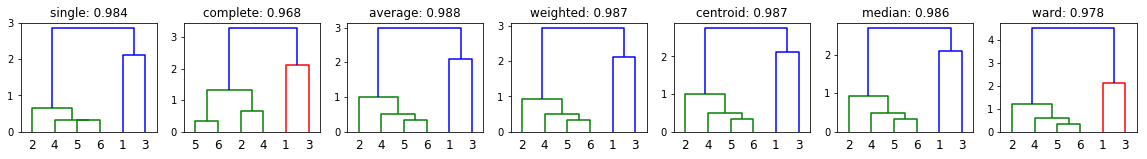

                                                                                        Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 2        1       Ах! мне помнится так ясно: был декабрь и день ненастный,  NinAstniJ  AstniJ  
                            2       Был как призрак — отсвет красный от камина моего.         maJivO     vO      
                            3       Ждал зари я в нетерпеньи, в книгах тщетно утешенье        uTišENJi   ENJi    
                            4       Я искал в ту ночь мученья, — бденья ночь, без той, кого   kavO       vO      
                            5       Звали здесь Линор. То имя… Шепчут ангелы его,             JivO       vO      
                            6       ‎На земле же — нет его.                                   JivO       vO      


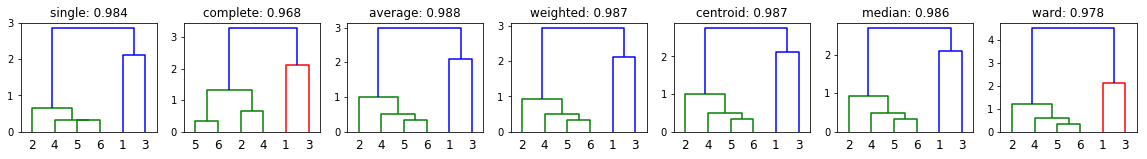

                                                                                    Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                           
brjusov_voron_1924 3        1       Шелковистый и не резкий, шорох алой занавески         zanaVEsKi  EsKi    
                            2       Мучил, полнил темным страхом, что не знал я до того.  datavO     vO      
                            3       Чтоб смирить в себе биенья сердца, долго в утешенье   vuTišENJi  ENJi    
                            4       Я твердил: «То — посещенье просто друга одного.»      adnavO     vO      
                            5       Повторял: «То — посещенье просто друга одного,        adnavO     vO      
                            6       ‎Друга, — больше ничего!»                             NiČivO     vO      


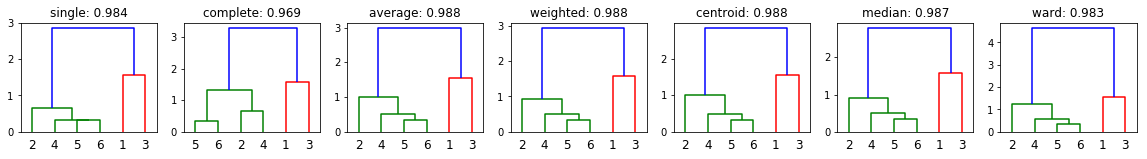

                                                                                   Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                          
brjusov_voron_1924 4        1       Наконец, владея волей, я сказал, не медля боле:      bOLi       OLi     
                            2       «Сэр иль Мистрисс, извините, что молчал я до того.   datavO     vO      
                            3       Дело в том, что задремал я, и не сразу расслыхал я,  raslixALi  ALi     
                            4       Слабый стук не разобрал я, стук у входа моего.»      maJivO     vO      
                            5       Говоря, открыл я настежь двери дома моего.           maJivO     vO      
                            6       ‎Тьма, — и больше ничего.                            NiČivO     vO      


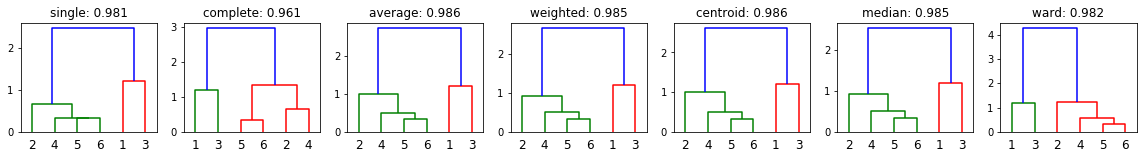

                                                                                     Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                           
brjusov_voron_1924 5        1       И, смотря во мрак глубокий, долго ждал я, одинокий,    aDinOKiJ  OKiJ    
                            2       Полный грез, что ведать смертным не давалось до того!  datavO    vO      
                            3       Все безмолвно было снова, тьма вокруг была сурова,     surOva    Ova     
                            4       Раздалось одно лишь слово: шепчут ангелы его.          JivO      vO      
                            5       Я шепнул: «Линор», и эхо — повторило мне его,          JivO      vO      
                            6       ‎Эхо, — больше ничего.                                 NiČivO    vO      


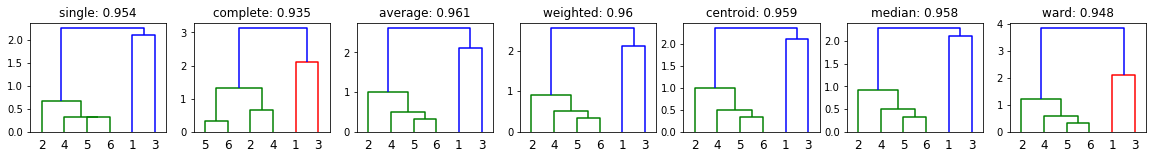

                                                                                     Text     RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 6        1       Лишь вернулся я несмело (вся душа во мне горела),      gaREla        Ela     
                            2       Вскоре вновь я стук расслышал, но ясней, чем до того.  datavO        vO      
                            3       Но сказал я: «Это ставней ветер зыблет своенравней,    svaJinrAvNiJ  AvNiJ   
                            4       Он и вызвал страх недавний, ветер, только и всего,     ifSivO        vO      
                            5       Будь спокойно, сердце! Это — ветер, только и всего.    ifSivO        vO      
                            6       ‎Ветер, — больше ничего!»                              NiČivO        vO      


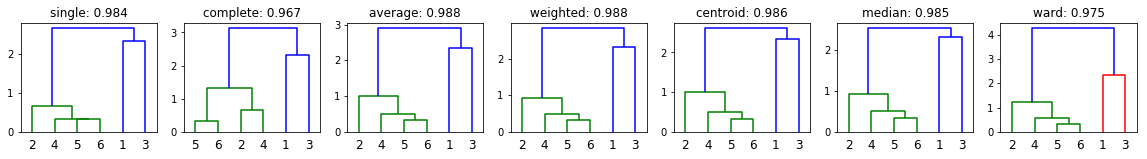

                                                                                      Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                             
brjusov_voron_1924 7        1       Растворил свое окно я, и влетел во глубь покоя          pakOJi     OJi     
                            2       Статный, древний Ворон, шумом крыльев славя торжество.  taržistvO  vO      
                            3       Поклониться не хотел он; не колеблясь, полетел он,      paLiTElan  Elan    
                            4       Словно лорд иль лэди, сел он, сел у входа моего,        maJivO     vO      
                            5       Там, на белый бюст Паллады, сел у входа моего,          maJivO     vO      
                            6       ‎Сел, — и больше ничего.                                NiČivO     vO      


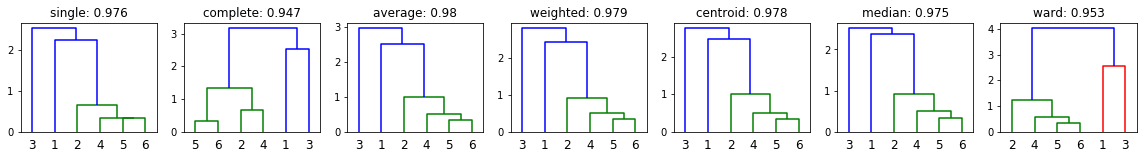

                                                                                            Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                  
brjusov_voron_1924 8        1       Я с улыбкой мог дивиться, как эбеновая птица,                 pTItsa    Itsa    
                            2       В строгой важности — сурова и горда была тогда.               tagdA     dA      
                            3       «Ты, — сказал я, — лыс и черен, но не робок и упорен,         iupORin   ORin    
                            4       Древний, мрачный Ворон, странник с берегов, где ночь всегда!  fSigdA    dA      
                            5       Как же царственно ты прозван у Плутона?» Он тогда             tagdA     dA      
                            6       ‎Каркнул: «Больше никогда!»                                   NikagdA   dA      


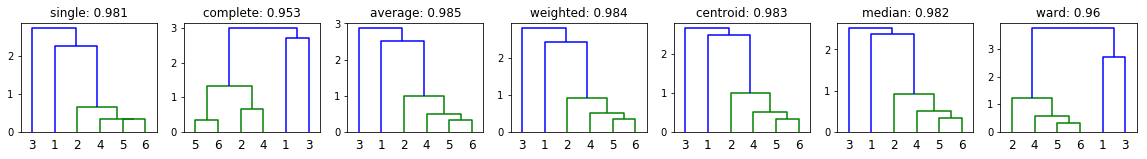

                                                                                Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                       
brjusov_voron_1924 9        1       Птица ясно прокричала, изумив меня сначала.       snaČAla    Ala     
                            2       Было в крике смысла мало, и слова не шли сюда.    SudA       dA      
                            3       Но не всем благословенье было — ведать посещенье  paSiQENJi  ENJi    
                            4       Птицы, что над входом сядет, величава и горда,    igardA     dA      
                            5       Что на белом бюсте сядет, чернокрыла и горда,     igardA     dA      
                            6       ‎С кличкой «Больше никогда!»                      NikagdA    dA      


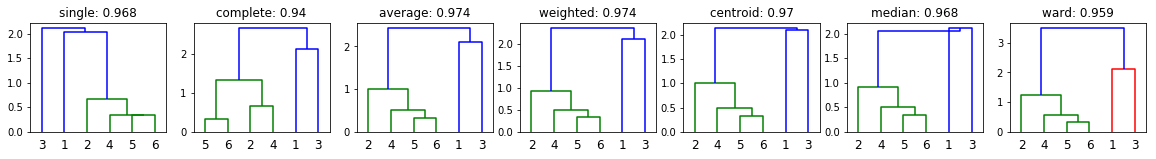

                                                                                      Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                            
brjusov_voron_1924 10       1       Одинокий, Ворон черный, сев на бюст, бросал, упорный,   upOrniJ   OrniJ   
                            2       Лишь два слова, словно душу вылил в них он навсегда.    nafSigdA  dA      
                            3       Их твердя, он словно стынул, ни одним пером не двинул,  NidVInul  Inul    
                            4       Наконец, я птице кинул: «Раньше скрылись без следа      BiSLidA   dA      
                            5       Все друзья; ты завтра сгинешь безнадежно!..» Он тогда   tagdA     dA      
                            6       ‎Каркнул: «Больше никогда!»                             NikagdA   dA      


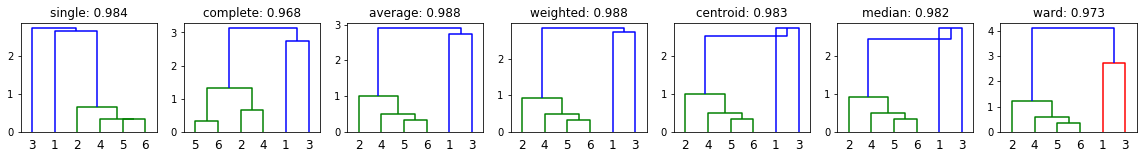

                                                                                          Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                
brjusov_voron_1924 11       1       Вздрогнул я, в волненьи мрачном, при ответе столь удачном.  udAČnam   AČnam   
                            2       «Это — все, — сказал я, — видно, что он знает, жив года     gadA      dA      
                            3       С бедняком, кого терзали беспощадные печали,                PiČALi    ALi     
                            4       Гнали в даль и дальше гнали неудачи и нужда.                inuždA    dA      
                            5       К песням скорби о надеждах лишь один припев нужда           nuždA     dA      
                            6       ‎Знала: больше никогда!»                                    NikagdA   dA      


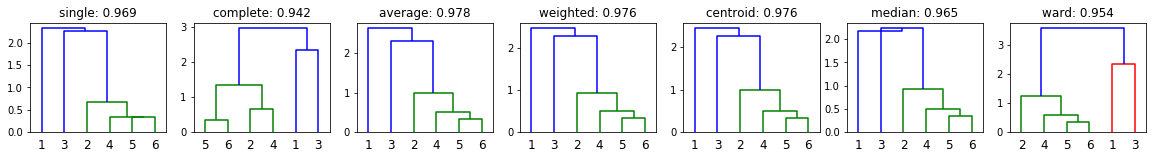

                                                                                      Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                            
brjusov_voron_1924 12       1       Я с улыбкой мог дивиться, как глядит мне в душу птица.  pTItsa    Itsa    
                            2       Быстро кресло подкатил я, против птицы, сел туда:       tudA      dA      
                            3       Прижимаясь к мягкой ткани, развивал я цепь мечтаний,    MiČtANiJ  ANiJ    
                            4       Сны за снами; как в тумане, думал я: «Он жил года,      gadA      dA      
                            5       Что ж пророчит, вещий, тощий, живший в старые года,     gadA      dA      
                            6       ‎Криком: больше никогда?»                               NikagdA   dA      


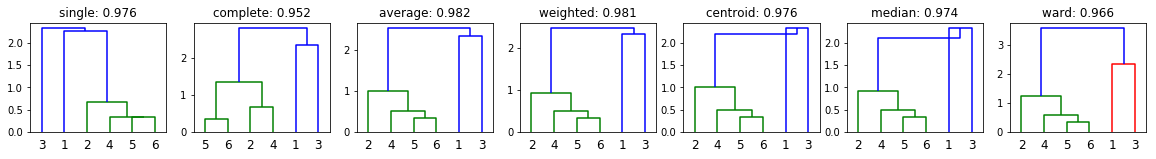

                                                                                   Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                         
brjusov_voron_1924 13       1       Это думал я с тревогой, но не смел шепнуть ни слога  NislOga   Oga     
                            2       Птице, чьи глаза палили сердце мне огнем тогда.      tagdA     dA      
                            3       Это думал и иное, прислонясь челом в покое           fpakOJi   OJi     
                            4       К бархату; мы, прежде, двое так сидели иногда…       inagdA    dA      
                            5       Ах! при лампе, не склоняться ей на бархат иногда     inagdA    dA      
                            6       ‎Больше, больше никогда!                             NikagdA   dA      


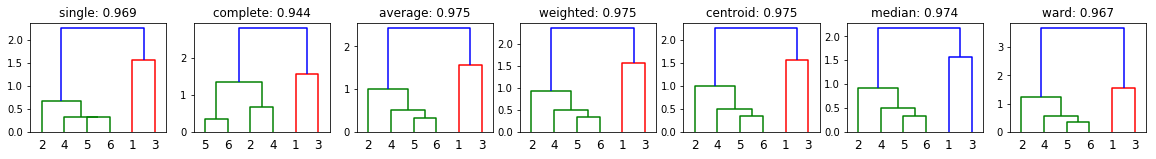

                                                                                             Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                   
brjusov_voron_1924 14       1       И, казалось, клубы дыма льет курильница незримо,               NizRIma   Ima     
                            2       Шаг чуть слышен серафима, с ней вошедшего сюда.                SudA      dA      
                            3       «Бедный! — я вскричал, — то богом послан отдых всем тревогам,  tRivOgam  Ogam    
                            4       Отдых, мир! чтоб хоть немного ты вкусил забвенье, — да?        dA        dA      
                            5       Пей! о, пей тот сладкий отдых! позабудь Линор, — о, да?        adA       dA      
                            6       ‎Ворон: «Больше никогда!»                                      NikagdA   dA      


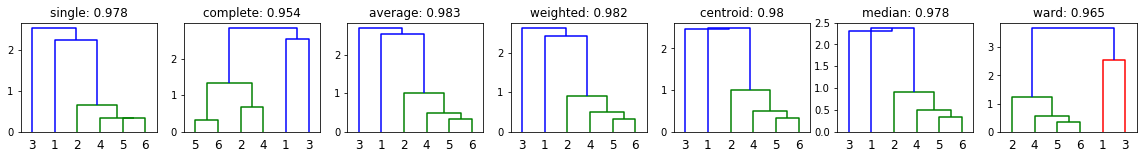

                                                                                         Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 15       1       «Вещий, — я вскричал, — зачем он прибыл, птица или демон?  iLiDEman  Eman    
                            2       Искусителем ли послан, бурей пригнан ли сюда?              SudA      dA      
                            3       Я не пал, хоть полн уныний! В этой за́клятой пустыне,      pustINi   INi     
                            4       Здесь, где правит ужас ныне, отвечай, молю, когда          kagdA     dA      
                            5       В Галааде мир найду я? обрету бальзам когда?»              kagdA     dA      
                            6       ‎Ворон: «Больше никогда!»                                  NikagdA   dA      


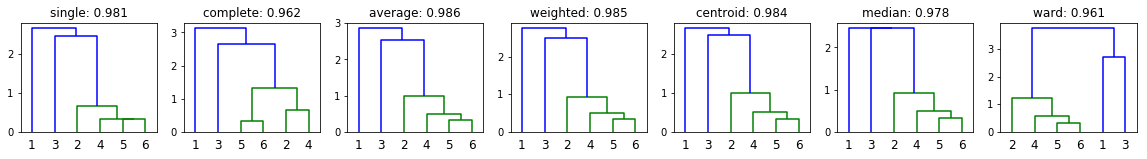

                                                                                         Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                               
brjusov_voron_1924 16       1       «Вещий, — я вскричал, — зачем он прибыл, птица или демон?  iLiDEman  Eman    
                            2       Ради неба, что над нами, часа страшного суда,              sudA      dA      
                            3       Отвечай душе печальной: я в раю, в отчизне дальной,        dALnaJ    ALnaJ   
                            4       Встречу ль образ идеальный, что меж ангелов всегда?        fSigdA    dA      
                            5       Ту мою Линор, чье имя шепчут ангелы всегда?»               fSigdA    dA      
                            6       ‎Ворон: «Больше никогда!»                                  NikagdA   dA      


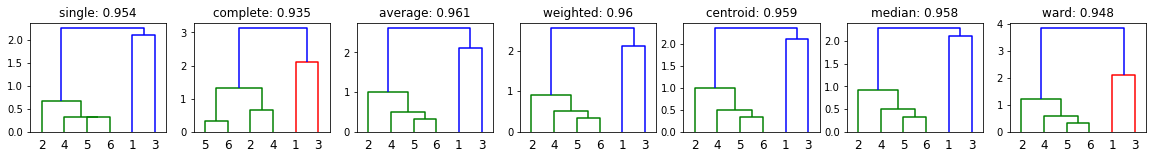

                                                                                            Text  RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                   
brjusov_voron_1924 17       1       «Это слово — знак разлуки! — крикнул я, ломая руки.           rUKi       UKi     
                            2       Возвратись в края, где мрачно плещет Стиксова вода!           vadA       dA      
                            3       Не оставь здесь перьев черных, как следов от слов позорных!   pazOrnix   Ornix   
                            4       Не хочу друзей тлетворных! С бюста — прочь, и навсегда!       inafSigdA  dA      
                            5       Прочь — из сердца клюв, и с двери — прочь виденье навсегда!»  nafSigdA   dA      
                            6       ‎Ворон: «Больше никогда!»                                     NikagdA    dA      


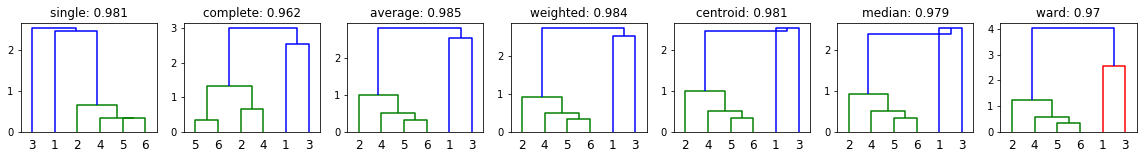

                                                                                          Text RhymeWord RhymeZone
PoemId             StanzaNo LineNo                                                                                
brjusov_voron_1924 18       1       И, как будто с бюстом слит он, все сидит он, все сидит он,  SiDItan   Itan    
                            2       Там, над входом, Ворон черный, с белым бюстом слит всегда!  fSigdA    dA      
                            3       Светом лампы озаренный, смотрит, словно демон сонный.       sOniJ     OniJ    
                            4       Тень ложится удлиненно, на полу лежит года, —               gadA      dA      
                            5       И душе не встать из тени, пусть идут, идут года, —          gadA      dA      
                            6       ‎Знаю, — больше никогда!                                    NikagdA   dA      


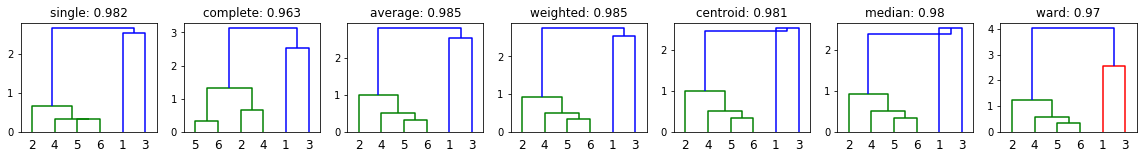

In [27]:
methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
stanzas = df_brjusov_voron.groupby(level=[0,1])
pd.set_option('display.width', 1000) # don't wrap long rows
for id, lines in stanzas:
    print(pd.concat([lines["Text"].str.replace(r"<[^>]+?>", ""), lines[["RhymeWord", "RhymeZone"]]], axis=1)) # diagnostic
    data = lines.copy().filter(regex=r"^token\d_") # only one-hot features
    labelList = list(range(1, len(lines)+1)) # labels are line numbers within stanza
    data.loc[:,"LineNo"] = [2 * n / len(labelList) for n in labelList] # scale to avoid tyranny of proximity
    plt.figure(figsize=(20, 2))
    for n, m in enumerate(methods):
        linked = linkage(data, method=m)
        m_c, m_coph_dist = cophenet(linked, pdist(data))
        plt.subplot(1, 7, n + 1)
        plt.title(m + ": " + str(round(m_c, 3)))
        dendrogram(linked, labels=labelList)
    plt.show()
pd.set_option('display.width', 80) # restore default

### Discussion

#### General

* The methods all produce comparable results with respect to finding the true correspondences first.
* The methods all have comparable very high cophenetic correlation coefficients, but perhaps this is expected of small datasets, and therefore not very interesting.
* No decision yet on where to cut the dendrogram. We want to cut because higher clusters are artifactual, that is, the methods all eventually fuse all of the items into a single cluster, even though they don’t belong there. Some other approaches seem to want to cut because they care about the higher-level clusters, which makes sense with large populations, but not in the case of rhyme. See also below, about singletons.

#### Differences

* Single linkage, uniquely, merges multiple adjacent perfect rhymes at the same level (4, 5, 6).
* Complete linkage forms all pairs before it adds to them.
* All other methods chain.

#### Issues

* Singletons (1, 3) sometimes pair with one another and sometimes chain off earlier clusters. Can this be used to distinguish rhyme from singleton status?

#### Thoughts

* We’ve defined rhyme as a function of phonetic similarity, proximity, and rhyme scheme (expectations). But is difference also a separate factor, i.e., do rhymes sets tend to contrast strongly to other rhyme sets in their vicinity? This could be explored by determining the rhyme scheme (on a second pass) and then measuring the distance between the last meaningful cluster and higher ones.

## To do

* Create callable function for pipeline to avoid repetition
* Keep EO sample in this worksheet and create another for full EO, Gippius, Brjusov
* Add other samples with more inexact rhyme and longer stanzas
* Begin analysis, not just visualization
    1. Stanza level
    1. Second pass, rhyme scheme and projection onto uncertain results